# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Datenbeschaffung

Die Daten haben wir [hier](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network) auf Kaggle gefunden. Sie bestehen aus folgenden Dateien:
- edges.csv
- nodes.csv
- hero-edge.csv

## Explorative Datenanalyse

Nachdem die Daten beschaffen wurden, sollen einfache Datenanalysen (Häufigkeitsanalyse, Statistiken, Daten-Visualisierungen...) helfen, die Daten besser zu verstehen und Unstimmigkeiten wie auch fehlende Werte in den Daten frühzeitig zu erkennen. Passen Sie wenn nötig ihre Programme zur Datensammlung und Daten-Transformationen an, wenn Sie Probleme mit der Datenqualität erkennen. Prüfen Sie auch (wenn möglich), ob die eingesammelten Daten plausibel sind und mit der Datenquelle / Realität (z.B: anhand einer Stichprobe) übereinstimmen. 

Mögliche Probleme: Dieser Schritt ist wichtig, ist aber schlussendlich im Bewertungsraster im Vergleich zu anderen Kriterien nur schwach gewichtet. Ich empfehle die Nutzung einer Python-Library wie z.B. Pandas Profiling oder Sweetviz, welche das Leben für die explorative Datenanalyse erheblich vereinfacht. Soziale Netzwerkanalyse In der Analysephase das das eingesammelte Netzwerk / die eingesammelten Netzwerke analysiert. Im Meilenstein haben Sie sich überlegen, welche Analysen Sie auf dem Netzwerk ausführen möchten. Es sollten verschiedene Analysen aus dem SAN-Unterricht sein. Sie dürfen aber gerne auch nicht im Unterricht behandelte Netzwerk-Analysen durchführen. Es ist auch gut möglich, dass Sie plötzlich im zweiten Teil noch weitere Ideen für Analysen haben, die Sie nicht im Meilenstein erwähnt haben.Diese dürfen Sie gerne umsetzen.

In [2]:
import os
import sys
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from pandas_profiling import ydata_profiling
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

from helper import *

/var/folders/l1/7lm0cqd933xgjvldmnsjpphh0000gn/T/ipykernel_64444/2581745738.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ydata_profiling


## Daten einlesen und betrachten

In [3]:
df_nodes = pd.read_csv('Daten/nodes.csv')
df_edges = pd.read_csv('Daten/edges.csv')

df_nodes.head()

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


- Nodes.csv: Dieser Datensatz enthält Informationen über verschiedene Knoten, die sich anscheinend auf Comic-Charaktere und -Ausgaben beziehen.
Die Spalten sind node und type, wobei node den Namen des Knotens (Charakter oder Ausgabe) und type den Typ (z.B. Comic oder Held) angibt.

In [4]:
df_edges.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


- Edges.csv: Dieser Datensatz repräsentiert die Beziehungen oder "Kanten" zwischen verschiedenen Knoten.
Es gibt zwei Spalten: hero und comic, die vermutlich die Verbindungen zwischen Comic-Helden und den Comic-Ausgaben, in denen sie erscheinen, darstellen.

In [5]:
# Basic statistics and frequency analysis

nodes_summary = df_nodes.describe(include='all')
node_type_counts = df_nodes['type'].value_counts()

print(nodes_summary)
print(node_type_counts)

           node   type
count     19090  19090
unique    19090      2
top     2001 10  comic
freq          1  12651
type
comic    12651
hero      6439
Name: count, dtype: int64


- Anzahl der Einträge: 19'090 Knoten.
- Einzigartigkeit: Jeder Knoten ist einzigartig (19'090 einzigartige Knoten).
- Knotentypen: Es gibt zwei Typen von Knoten - comic und hero.
    - Anzahl der Comics: 12'651
    - Anzahl der Helden: 6'439

In [6]:
# Basic statistics and frequency analysis

edges_summary = df_edges.describe(include='all')
print(edges_summary)

                           hero  comic
count                     96104  96104
unique                     6439  12651
top     SPIDER-MAN/PETER PARKER  COC 1
freq                       1577    111


- Anzahl der Einträge: 96'104 Kanten.
- Einzigartigkeit:
    - Einzigartige Helden: 6'439
    - Einzigartige Comics: 12'651
- Häufigste Verbindungen:
    - Der am häufigsten vorkommende Held ist SPIDER-MAN/PETER PARKER (1'577 Erwähnungen).
    - Der am häufigsten vorkommende Comic ist COC 1 (111 Erwähnungen).

## Prognose der Datenqualität
Nun werden wir die Daten auf Volllständigkeit und Konsistenz überprüfen (fehlende Werte überprüfen und die Qualität der Daten). Dies ist entscheidend, um festzustellen, ob Anpassungen in den Programmen zur Datensammlung und Daten-Transformationen erforderlich sind. 

### Jahr untersuchen

In [7]:
import re

# Filter out only the comics from the nodes dataset
df_comics = df_nodes[df_nodes['type'] == 'comic'].copy()

# Function to check if a string contains a year (four consecutive digits)
def contains_year(string):
    return bool(re.search(r'\b\d{4}\b', string))

# Apply function to the comic names
df_comics['contains_year'] = df_comics['node'].apply(contains_year)

# Calculate number and percentage of comics with and without a year
comics_with_year = df_comics['contains_year'].sum()
total_comics = len(df_comics)
comics_without_year = total_comics - comics_with_year
percentage_with_year = (comics_with_year / total_comics) * 100
percentage_without_year = (comics_without_year / total_comics) * 100

comics_with_year, comics_without_year, percentage_with_year, percentage_without_year

(13, 12638, 0.10275867520354123, 99.89724132479645)

Wir stellen fest, dass nur 13 Comics ein Jahr besitzen also 0.1% der Comics.

### Fehlende Werte untersuchen

In [8]:
print(df_nodes.isna().sum())
print(df_edges.isna().sum())

node    0
type    0
dtype: int64
hero     0
comic    0
dtype: int64


Glücklicherweise enthalten sowohl der nodes.csv als auch der edges.csv Datensatz keine fehlenden Werte. Jede Spalte in beiden Datensätzen ist vollständig ausgefüllt. Dies ist ein positives Zeichen für die Datenqualität in Bezug auf Vollständigkeit.

In [9]:
# 1. Überprüfung, ob es Duplikate im `node` Attribut gibt.
duplicate_nodes = df_nodes[df_nodes.duplicated(subset=['node'], keep=False)]

# 2. Überprüfung, ob es Knoten ohne den `type` Attribut gibt oder ob es unerwartete Typwerte gibt.
nodes_without_type = df_nodes[df_nodes['type'].isnull()]
unique_types = df_nodes['type'].unique()

# 3. Überprüfung, ob es Kanten gibt, die zwei Helden oder zwei Comics verbinden.
# Zuerst erstellen wir ein Set von Helden und Comics
heroes_set = set(df_nodes[df_nodes['type'] == 'hero']['node'])
comics_set = set(df_nodes[df_nodes['type'] == 'comic']['node'])

# Überprüfung , ob beide Enden der Kante im Helden-Set oder im Comic-Set sind
invalid_edges_hero_hero = df_edges[(df_edges['hero'].isin(heroes_set)) & (df_edges['comic'].isin(heroes_set))]
invalid_edges_comic_comic = df_edges[(df_edges['hero'].isin(comics_set)) & (df_edges['comic'].isin(comics_set))]

{
    "duplicate_nodes": duplicate_nodes.shape[0],
    "nodes_without_type": nodes_without_type.shape[0],
    "unique_types": list(unique_types),
    "invalid_edges_hero_hero": invalid_edges_hero_hero.shape[0],
    "invalid_edges_comic_comic": invalid_edges_comic_comic.shape[0]
}

{'duplicate_nodes': 0,
 'nodes_without_type': 0,
 'unique_types': ['comic', 'hero'],
 'invalid_edges_hero_hero': 0,
 'invalid_edges_comic_comic': 0}

Basierend auf diesen Ergebnissen scheint die Datenqualität insgesamt gut zu sein, zumindest in Bezug auf die Punkte, die wir überprüft haben.

## Visualisierungen

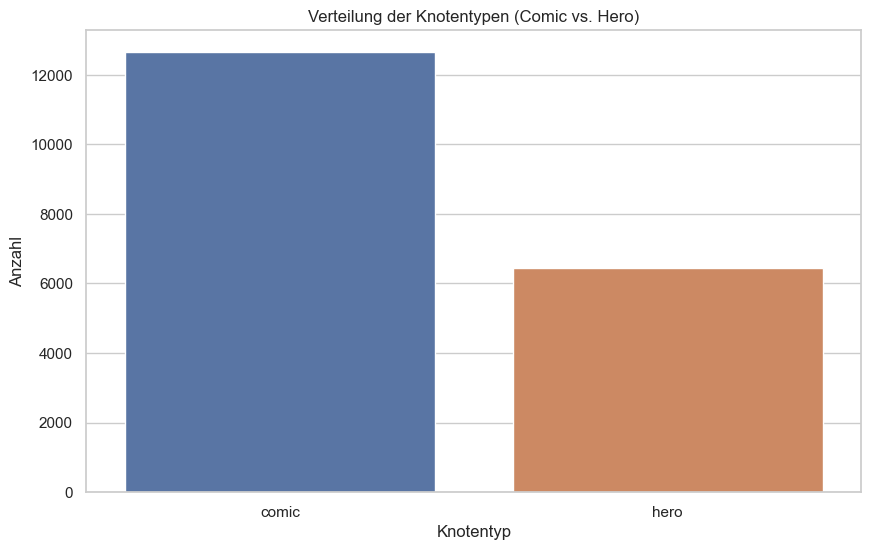

In [10]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot the distribution of node types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df_nodes)
plt.title('Verteilung der Knotentypen (Comic vs. Hero)')
plt.xlabel('Knotentyp')
plt.ylabel('Anzahl')
plt.show()

Verteilung der Knotentypen (Comic vs. Hero): Die Anzahl der Comics überwiegt deutlich gegenüber der Anzahl der Helden.

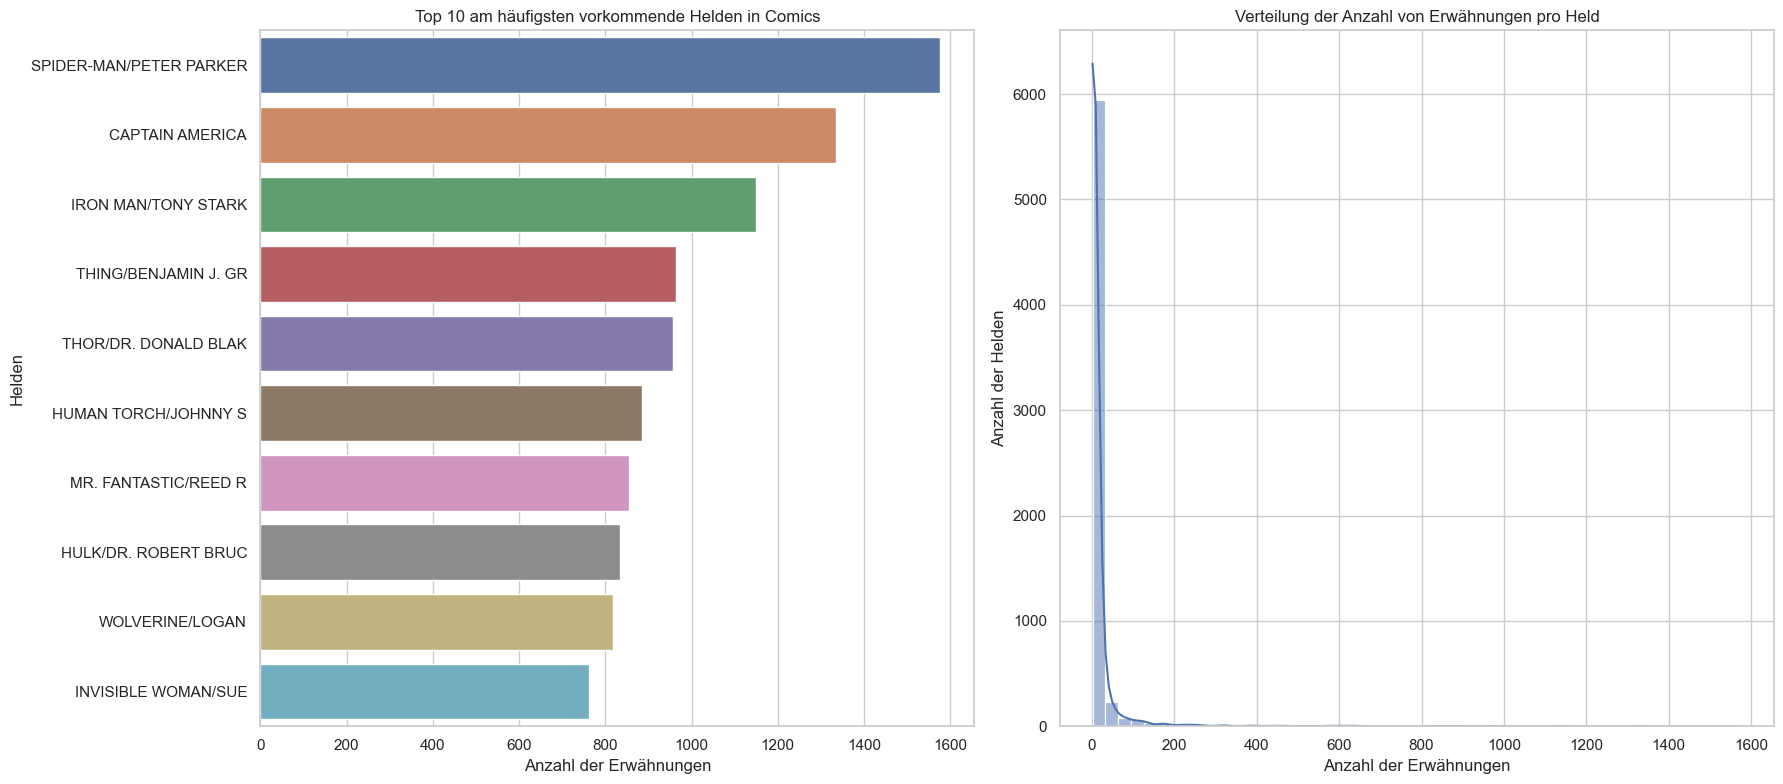

In [11]:
# Count the number of mentions for each hero
hero_mentions = df_edges['hero'].value_counts()
top_heroes = hero_mentions.head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_heroes.values, y=top_heroes.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Helden in Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Helden')

# Distribution plot of mentions per comic
sns.histplot(hero_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Held')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Helden')

plt.tight_layout()
plt.show()

Top 10 am häufigsten vorkommende Helden in Comics: Spider-Man/Peter Parker führt die Liste an, gefolgt von anderen bekannten Helden wie Captain America, Iron Man und Thor.

Die Verteilung ist stark rechtsschief, was bedeutet, dass eine grosse Anzahl von Helden nur wenige Male erwähnt wird, während eine kleine Anzahl von Helden sehr häufig vorkommt. Es gibt einige wenige Helden, die extrem häufig erwähnt werden, was auf zentrale oder sehr populäre Charaktere hindeutet. Die Mehrheit der Helden wird jedoch relativ selten erwähnt.

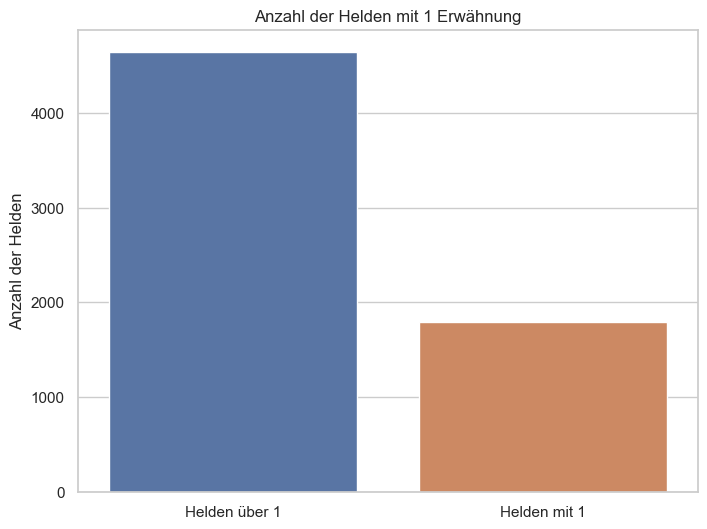

In [12]:
# Count number of heroes with more than 1 mentions and less than or equal to 1 mentions
heroes_over_1 = hero_mentions[hero_mentions > 1].count()
heroes_under_or_equal_1 = hero_mentions[hero_mentions <= 1].count()

plt.figure(figsize=(8, 6))
sns.barplot(x=['Helden über 1', 'Helden mit 1'], y=[heroes_over_1, heroes_under_or_equal_1])
plt.title('Anzahl der Helden mit 1 Erwähnung')
plt.ylabel('Anzahl der Helden')
plt.show()

Die Entscheidung, Daten zu reduzieren, indem Helden mit weniger als 2 Erwähnungen entfernt werden, hängt von dem Ziel der Analyse ab.

### Pro Argumente für die Reduzierung der Datenmenge:
1. **Fokus auf Populäre Charaktere:** Die Beschränkung auf häufig erwähnte Helden ermöglicht eine gezieltere Analyse der beliebtesten oder einflussreichsten Charaktere.
2. **Vereinfachung der Analyse:** Eine kleinere Datenmenge kann die Analyse vereinfachen, insbesondere bei rechenintensiven Methoden oder Visualisierungen.
3. **Verbesserte Interpretierbarkeit:** Weniger Helden könnten zu klareren Mustern oder Trends führen und die Interpretation der Ergebnisse erleichtern.

### Contra Argumente gegen die Reduzierung der Datenmenge:
1. **Verlust von Informationen:** Durch das Entfernen von Helden mit weniger Erwähnungen könnten interessante Muster oder Beziehungen verloren gehen, insbesondere wenn es um die Analyse von Nischencharakteren oder weniger bekannten Geschichten geht.
2. **Verzerrung der Ergebnisse:** Die Konzentration auf nur populäre Charaktere könnte zu einer verzerrten Sicht auf das gesamte Comic-Universum führen, da es den Eindruck erwecken könnte, dass nur diese Charaktere von Bedeutung sind.
3. **Verlust der Vielfalt:** Die Vielfalt der Charaktere und ihre unterschiedlichen Rollen könnten in der Analyse unterrepräsentiert sein, wenn nur die am häufigsten erwähnten Helden berücksichtigt werden.

In [26]:
# Filter out heroes with 2 or fewer mentions
filtered_edges_df = df_edges[df_edges['hero'].isin(hero_mentions[hero_mentions > 1].index)]

# Verify the filter by counting the number of heroes again
filtered_hero_mentions = filtered_edges_df['hero'].value_counts()
print(filtered_hero_mentions.shape)

(4644,)


In [21]:
filtered_hero_mentions.describe()

count    4644.000000
mean       20.307709
std        69.042676
min         2.000000
25%         3.000000
50%         5.000000
75%        13.000000
max      1577.000000
Name: count, dtype: float64

Wir sehen, dass die durchschnittliche Anzahl Erwähnungen pro Held 14.9 beträgt, während die Standardabweichung 72.4 beträgt. Dies bestätigt wiederum, dass die meisten Helden relativ selten erwähnt werden, während einige wenige Helden extrem häufig erwähnt werden.

In [27]:
filtered_comics_mentions = filtered_edges_df['comic'].value_counts()
filtered_comics_mentions

comic
COC 1      111
IW 3        90
H2 279      87
IW 1        81
IW 4        80
          ... 
DDS 4        1
DDS 5        1
DDS 6        1
DDS 7        1
WI 25/2      1
Name: count, Length: 12634, dtype: int64

Wir haben also die Anzahl der Helden von 6439 auf 4644 reduziert, indem wir Helden mit nur 1 Erwähnung entfernt haben. Dies hat die Anzahl um 27.8% reduziert.

**Comics mit meisten Helden**

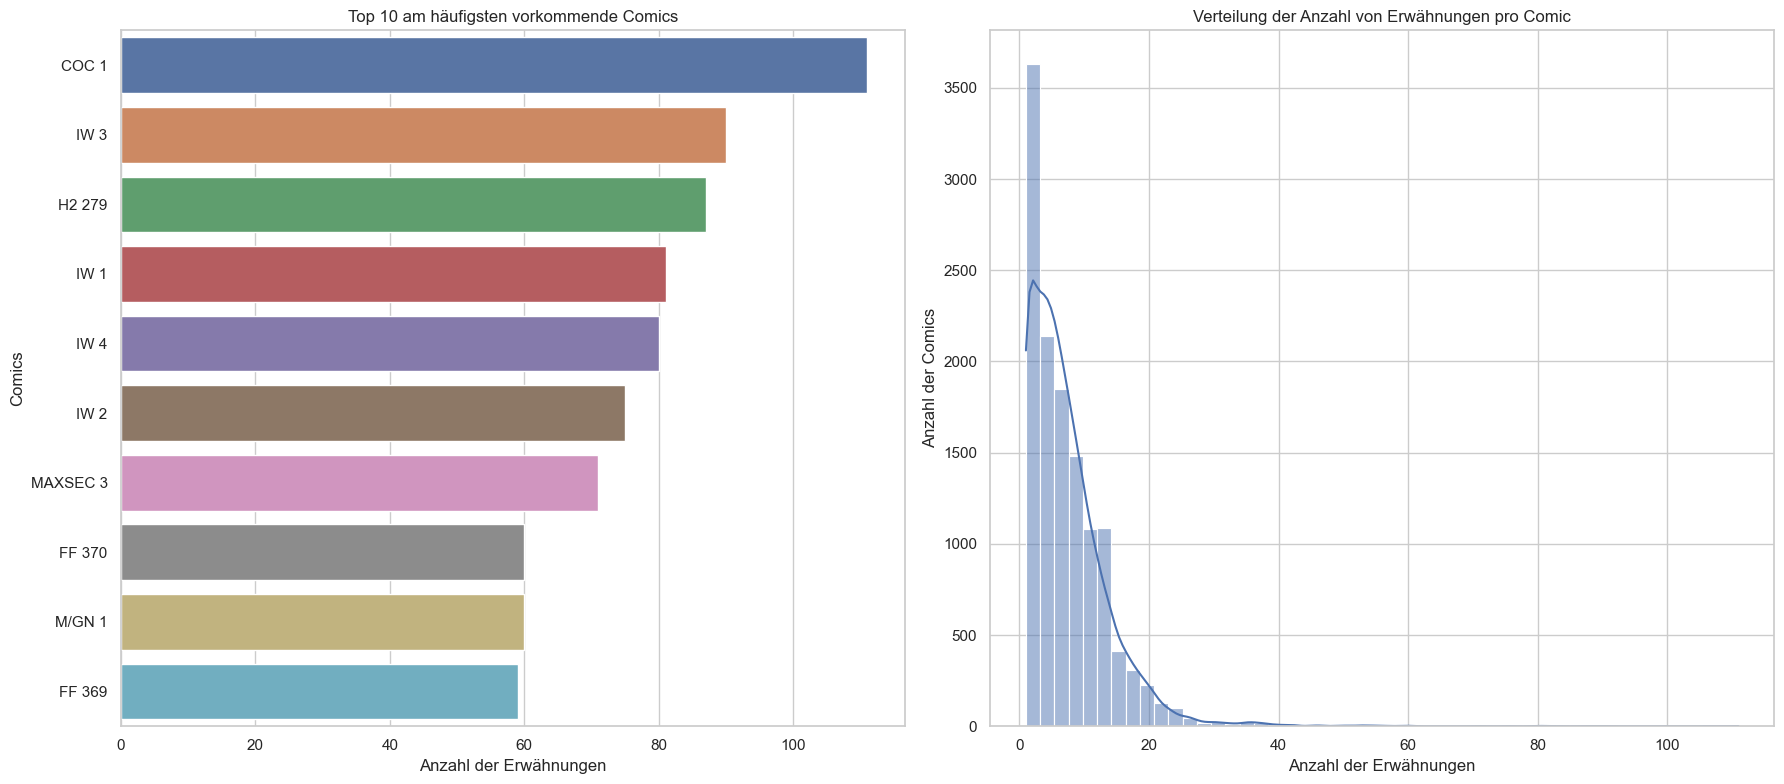

In [28]:
top_comics = filtered_comics_mentions.head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_comics.values, y=top_comics.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Comics')

# Distribution plot of mentions per comic
sns.histplot(filtered_comics_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Comic')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Comics')

plt.tight_layout()
plt.show()

- Top 10 am häufigsten vorkommende Comics: Dieses Balkendiagramm zeigt die Comics, die am häufigsten in den Daten erwähnt werden. Es hebt die populärsten Comics hervor, basierend auf der Häufigkeit ihrer Erwähnungen.

- Verteilung der Anzahl von Erwähnungen pro Comic: Dieser Distributionsplot zeigt, wie oft Comics insgesamt erwähnt werden. Ähnlich wie bei den Helden ist die Verteilung rechtsschief, was darauf hindeutet, dass die meisten Comics nur wenige Male erwähnt werden, während einige wenige sehr oft vorkommen.

## Plausibilitätsprüfung
Für die Plausibilitätsprüfung ist es wichtig, die Daten mit externen Quellen oder dem erwarteten Wissen zu vergleichen. Wir werden folgende Aspekte berücksichtigen:

- Vergleich mit bekannten Fakten: Überprüfen, ob die am häufigsten vorkommenden Helden und Comics mit dem übereinstimmen, was in der Realität oder in bekannten Datenbanken zu erwarten ist.

- Konsistenzprüfung: Sicher stellen dass die Beziehungen zwischen Helden und Comics logisch sind. Zum Beispiel sollte ein Held nicht in einem Comic auftauchen, der vor seiner Einführung veröffentlicht wurde.

### Erkenntnisse

Häufigsten Helden:
- Da wir diese Helden gut kennen, müssen wir sie nicht überprüfen.

Da die Comics abgekürzt sind und wir nicht wissen, welche Comics sie repräsentieren, werden wir sie mit externen Quellen vergleichen.

Häufigsten Comics:
- COC (Contest of Champions): https://marvel.fandom.com/wiki/Marvel_Super_Hero_Contest_of_Champions_Vol_1_1
- IW (Infinity War): https://marvel.fandom.com/wiki/Infinity_War_Vol_1_1
- FF (Fantastic Four): https://marvel.fandom.com/wiki/Fantastic_Four_Vol_1_1
- MAXSEC (Maximum Security): https://marvel.fandom.com/wiki/Maximum_Security_Vol_1_1
- H2 (House of M): https://marvel.fandom.com/wiki/House_of_M_Vol_1_1
- M/GN (Marvel Graphic Novel): https://marvel.fandom.com/wiki/Marvel_Graphic_Novel_Vol_1